# Introduction to CREsted with Peak Regression

In this introductory notebook, we will train a peak regression model on the mouse BICCN data and inspect the results to get a feel for the capabilities of the CREsted package.  

## Import Data

For this tutorial, we will use the mouse BICCN dataset which is available in the {func}`~crested.get_dataset` function.  
To train a CREsted peak regression model on your data, you need: 
1. A consensus regions BED file containing all the regions of interest accross cell types.
2. A folder containing the bigwig files per cell type. Each file should be named according to the cell type: {cell type name}.bw.
3. A genome fasta file and optionally a chromosome sizes file.

You could use a tool like SnapATAC2 to generate the consensus regions and bigwig files from your own data.

In [39]:
# Feel free to ignore this, necessary for my own setup
import os
os.environ["PATH"] = "/data/projects/c04/cbd-saerts/nkemp/tools:" + os.environ["PATH"]
import sys
sys.path.insert(0, '/home/VIB.LOCAL/niklas.kempynck/.conda/envs/crested/lib/python3.11/site-packages')
sys.path.insert(0,'/data/projects/c04/cbd-saerts/nkemp/software/CREsted/src')
sys.path.insert(0, '/data/projects/c04/cbd-saerts/nkemp/tools/')

In [40]:
import crested

In [ ]:
# Download the tutorial data
import os

os.environ[
    "CRESTED_DATA_DIR"
] = "../../../Crested_testing/data/tmp"  # Change this to your desired directory
bigwigs_folder, regions_file = crested.get_dataset("mouse_cortex_bigwig")

Or if you have the data already available:

In [8]:
bigwigs_folder='/home/VIB.LOCAL/niklas.kempynck/nkemp/mouse/biccn/bigwigs/bws/'
regions_file = "/home/VIB.LOCAL/niklas.kempynck/nkemp/mouse/biccn/consensus_peaks_inputs.bed"
chromsizes_file = '/home/VIB.LOCAL/niklas.kempynck/nkemp/mouse/biccn/mm.chrom.sizes'

We can use the {func}`~crested.import_bigwigs` function to import bigwigs per cell type and a consensus regions BED file into an {class}`anndata.AnnData` object,
with the imported cell types as the `AnnData.obs` and the consensus peak regions as the `AnnData.var`.  

Optionally, provide a chromsizes file to filter out regions that are not within the chromsizes. 

In [6]:
adata = crested.import_bigwigs(
    bigwigs_folder=bigwigs_folder,
    regions_file=regions_file,
    target_region_width=1000,  # optionally, use a different width than the consensus regions file (500bp) for the .X values calculation
    chromsizes_file=chromsizes_file,
    target="mean",  # or "max", "count", "logcount" --> what we will be predicting
)
adata

2024-09-25T13:12:19.585474+0200 INFO Extracting values from 19 bigWig files...


AnnData object with n_obs × n_vars = 19 × 546993
    obs: 'file_path'
    var: 'chr', 'start', 'end'

To train a model, we always need to add a *split* column to our dataset, which we can do using {func}`crested.pp.train_val_test_split`.  
This will add a column to the `AnnData.obs` with the split type for each region (train, val, or test).

In [7]:
# Choose the chromosomes for the validation and test sets
crested.pp.train_val_test_split(
    adata, strategy="chr", val_chroms=["chr8", "chr10"], test_chroms=["chr9", "chr18"]
)

# Alternatively, We can split randomly on the regions
# crested.pp.train_val_test_split(
#     adata, strategy="region", val_size=0.1, test_size=0.1, random_state=42
# )

print(adata.var["split"].value_counts())
adata.var

split
train    440993
val       56064
test      49936
Name: count, dtype: int64


,chr,start,end,split
region,,,,
chr1:3093998-3096112,chr1,3093998,3096112,train
chr1:3094663-3096777,chr1,3094663,3096777,train
chr1:3111367-3113481,chr1,3111367,3113481,train
chr1:3112727-3114841,chr1,3112727,3114841,train
chr1:3118939-3121053,chr1,3118939,3121053,train
...,...,...,...,...
chrX:169878506-169880620,chrX,169878506,169880620,train
chrX:169879374-169881488,chrX,169879374,169881488,train
chrX:169924670-169926784,chrX,169924670,169926784,train


## Preprocessing

### Region Width

For this example we're interested in training on wider regions than our consensus regions file (500bp) to also include some sequence information from the tails of our peaks.  

We change it to 2114 bp regions since that is what chrombpnet was originally trained on and that's the model architecture we'll be using.  
This is an arbitrary choice and can be changed to any width you prefer.  
Wider regions will mean that you don't only include sequence information from the center of the peaks and could effectively increase your dataset size if the tails of the peak include meaningful information, but could also introduce noise if the tails are not informative.  
Wider regions will also increase the computational cost of training the model. 

In [9]:
crested.pp.change_regions_width(
    adata, 2114,chromsizes_file='/home/VIB.LOCAL/niklas.kempynck/nkemp/mouse/biccn/mm.chrom.sizes'
)  # change the adata width of the regions to 2114bp

### Peak Normalization

Additionally, we can normalize our peak values based on the variability of the top peak heights per cell type using the {func}`crested.pp.normalize_peaks` function.  

This function applies a normalization scalar to each cell type, obtained by comparing per cell type the distribution of peak heights for the maximally accessible regions which are not specific to any cell type.

In [10]:
crested.pp.normalize_peaks(adata, top_k_percent=0.03) # The top_k_percent parameters can be tuned based on potential bias towards cell types. If some weights are overcompensating too much, consider increasing the top_k_percent. Default is 0.01

2024-09-25T13:15:44.518390+0200 INFO Filtering on top k Gini scores...
2024-09-25T13:15:50.258880+0200 INFO Added normalization weights to adata.obsm['weights']...


,chr,start,end,split
region,,,,
chr5:76656624-76658738,chr5,76656624,76658738,train
chr9:65587095-65589209,chr9,65587095,65589209,test
chr9:65604601-65606715,chr9,65604601,65606715,test
chr19:18669675-18671789,chr19,18669675,18671789,train
chr19:18670209-18672323,chr19,18670209,18672323,train
...,...,...,...,...
chr9:65461589-65463703,chr9,65461589,65463703,test
chr5:76564462-76566576,chr5,76564462,76566576,train
chr13:30711675-30713789,chr13,30711675,30713789,train


We can visualize the normalization factor for each cell type using the {func}`crested.pl.bar.normalization_weights` function to inspect which cell type peaks were up/down weighted.

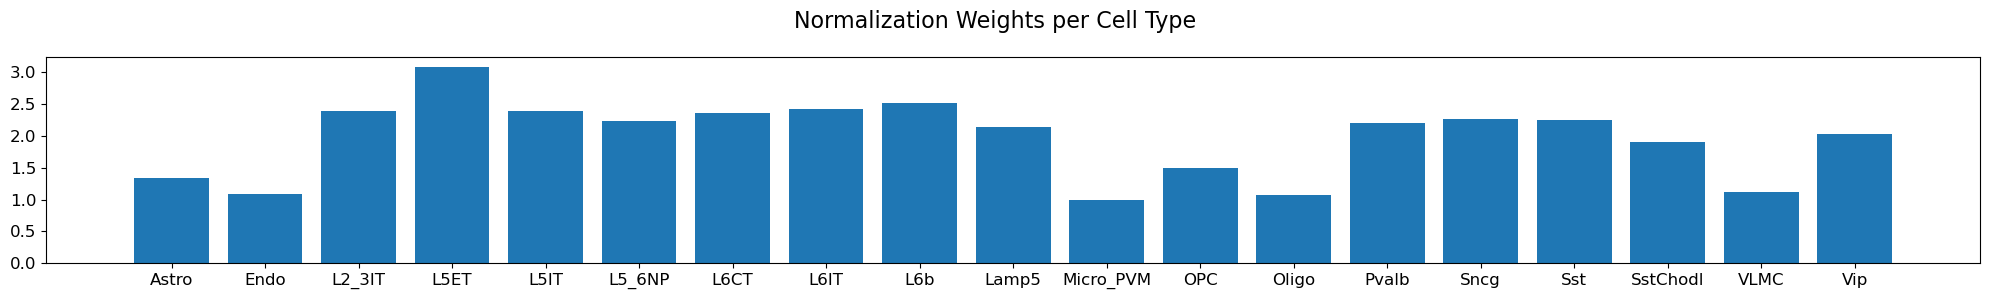

In [11]:
%matplotlib inline
crested.pl.bar.normalization_weights(adata, title="Normalization Weights per Cell Type")

There is no single best way to preprocess your data, so we recommend experimenting with different preprocessing steps to see what works best for your data.  
Likewise there is no single best training approach, so we recommend experimenting with different training strategies.

In [12]:
# Save the final preprocessing results
adata.write_h5ad("mouse_biccn_data.h5ad")

## Model Training

The entire CREsted workflow is built around the {func}`crested.tl.Crested` class.
Everything that requires a model (training, evaluation, prediction) is done through this class.  
This class has a couple of required arguments:
- `data`: the {class}`crested.tl.data.AnnDataModule` object containing all the data (anndata, genome) and dataloaders that specify how to load the data.
- `model`: the {class}`keras.Model` object containing the model architecture.
- `config`: the {class}`crested.tl.TaskConfig` object containing the optimizer, loss function, and metrics to use in training.  

Generally you wouldn't run these steps in a notebook, but rather in a script or a python file so you could run it on a cluster or in the background.

### Data

We'll start by initializing the {class}`crested.tl.data.AnnDataModule` object with our data.  
This will tell our model how to load the data and what data to load during fitting/evaluation.
The main arguments to supply are the `adata` object, the `genome` file path, and the `batch_size`.  
Other optional arguments are related to the training data loading (e.g. shuffling, whether to load the sequences into memory, ...).

The genome file you need to provide yourself as this is not included in the crested package.

In [9]:
import crested

In [13]:
# read in your preprocessed data
import anndata

adata = anndata.read_h5ad("mouse_biccn_data.h5ad")

In [105]:
genome_file = "/home/VIB.LOCAL/niklas.kempynck/nkemp/software/dev_DeepPeak/DeepPeak/data/raw_mm/genome.fa"
datamodule = crested.tl.data.AnnDataModule(
    adata,
    genome_file=genome_file,
    batch_size=256,  # lower this if you encounter OOM errors
    max_stochastic_shift=3,  # optional augmentation
    always_reverse_complement=True,  # default True. Will double the effective size of the training dataset.
)

2024-09-25T14:17:49.919133+0200 WARNING Chromsizes file not provided when shifting. Will not check if shifted regions are within chromosomes


### Model definition 

Next, we'll define the model architecture. This is a standard Keras model definition, so you can provide your own model definition if you like.  
Alternatively, there are a couple of ready-to-use models available in the `crested.tl.zoo` module.  
Each of them require the width of the input sequences and the number of output classes (your `Anndata.obs`) as arguments.

In [17]:
# Load chrombpnet architecture for a dataset with 2114bp regions and 19 cell types
model_architecture = crested.tl.zoo.chrombpnet(seq_len=2114, num_classes=len(list(adata.obs_names)))

2024-09-25 13:23:44.193365: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78790 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:55:00.0, compute capability: 9.0


### TaskConfig

The TaskConfig object specifies the optimizer, loss function, and metrics to use in training (we call this our 'task').  
Some default configurations are available for some common tasks such as 'topic_classification' and 'peak_regression',
which you can load using the {func}`crested.tl.default_configs` function.  

In [23]:
# Load the default configuration for training a peak regression model
from crested.tl import default_configs, TaskConfig

config = default_configs("peak_regression") # or "topic_classification" for topic classification
print(config)

# If you want to change some small parameters to an existing config, you can do it like this
# For example, the default learning rate is 0.001, but you can change it to 0.0001
# config.optimizer.learning_rate = 0.0001

TaskConfig(optimizer=<keras.src.optimizers.adam.Adam object at 0x7f163fc274d0>, loss=<crested.tl.losses._cosinemse_log.CosineMSELogLoss object at 0x7f1647e70710>, metrics=[<MeanAbsoluteError name=mean_absolute_error>, <MeanSquaredError name=mean_squared_error>, <CosineSimilarity name=cosine_similarity>, <PearsonCorrelation name=pearson_correlation>, <ConcordanceCorrelationCoefficient name=concordance_correlation_coefficient>, <PearsonCorrelationLog name=pearson_correlation_log>, <ZeroPenaltyMetric name=zero_penalty_metric>])


Alternatively, you can create your own TaskConfig object and specify the optimizer, loss function, and metrics yourself if you want to do something completely custom.

In [29]:
# Create your own configuration
# I recommend trying this for peak regression with a weighted cosine mse log loss function
from crested.tl import default_configs, TaskConfig

import keras

optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss = crested.tl.losses.CosineMSELogLoss(max_weight=100)
metrics = [
            keras.metrics.MeanAbsoluteError(),
            keras.metrics.MeanSquaredError(),
            keras.metrics.CosineSimilarity(axis=1),
            crested.tl.metrics.PearsonCorrelation(),
            crested.tl.metrics.ConcordanceCorrelationCoefficient(),
            crested.tl.metrics.PearsonCorrelationLog(),
            crested.tl.metrics.ZeroPenaltyMetric(),
]
        
alternative_config = TaskConfig(optimizer, loss, metrics)
print(alternative_config)

TaskConfig(optimizer=<keras.src.optimizers.adam.Adam object at 0x7f1647f85ad0>, loss=<crested.tl.losses._cosinemse_log.CosineMSELogLoss object at 0x7f164809a690>, metrics=[<MeanAbsoluteError name=mean_absolute_error>, <MeanSquaredError name=mean_squared_error>, <CosineSimilarity name=cosine_similarity>, <PearsonCorrelation name=pearson_correlation>, <ConcordanceCorrelationCoefficient name=concordance_correlation_coefficient>, <PearsonCorrelationLog name=pearson_correlation_log>, <ZeroPenaltyMetric name=zero_penalty_metric>])


### Training

Now we're ready to train our model.
We'll create a {class}`~crested.tl.Crested` object with the data, model, and config objects we just created.  
Then, we can call the {meth}`~crested.tl.Crested.fit` method to train the model.  
Read the documentation for more information on all available arguments to customize your training (e.g. augmentations, early stopping, checkpointing, ...).  

By default: 
1. The model will continue training until the validation loss stops decreasing for 10 epochs with a maximum of 100 epochs.  
2. Every best model is saved based on the validation loss.
3. The learning rate reduces by a factor of 0.25 if the validation loss stops decreasing for 5 epochs.

In [25]:
# setup the trainer
trainer = crested.tl.Crested(
    data=datamodule,
    model=model_architecture,
    config=alternative_config,
    project_name="mouse_biccn",  # change to your liking
    run_name="dyn_log_loss",  # change to your liking
    logger='wandb',  # or 'wandb', 'tensorboard'
)

In [ ]:
# train the model
trainer.fit(epochs=60)

### Finetuning on cell type-specific regions

#### Subsetting the consensuspeak set

For peak regression models, we recommend to continue training the model trained on all consensuspeaks on a subset of cell type-specific regions.
Since we are interested in understanding the enhancer code uniquely identifying the cell types in the dataset, finetuning on specific regions will allow us to approach that.
We define specific regions as regions with a high Gini index, indicating that their peak distribution over all cell types will be skewed and specific for one or more cell types.

Read the documentation of the {func}`crested.pp.filter_regions_on_specificity` function for more information on how the filtering is done.  

In [26]:
crested.pp.filter_regions_on_specificity(adata, gini_std_threshold=1.0) # All regions with a Gini index 1 std above the mean across all regions will be kept
adata

2024-09-25T13:34:36.076154+0200 INFO After specificity filtering, kept 88835 out of 546993 regions.


AnnData object with n_obs × n_vars = 19 × 88835
    obs: 'file_path'
    var: 'chr', 'start', 'end', 'split'
    obsm: 'weights'

In [28]:
adata.write_h5ad("mouse_biccn_data_filtered.h5ad")

#### Loading the pretrained model on all consensuspeaks and finetuning with lower learning rate

In [106]:
datamodule = crested.tl.data.AnnDataModule(
    adata,
    genome_file=genome_file,
    batch_size=64,  # Recommended to go for a smaller batch size than in the pretrained model
    max_stochastic_shift=3,  
    always_reverse_complement=True,  
)

2024-09-25T14:18:02.963100+0200 WARNING Chromsizes file not provided when shifting. Will not check if shifted regions are within chromosomes


In [35]:
# First load the pretrained model on all peaks
import keras
model_architecture=keras.models.load_model('deeppeak_benchmarking/dyn_log_loss/checkpoints/18.keras', compile=False)

In [36]:
# Use the same config you used for the pretrained model. EXCEPT THE LEARNING RATE, make sure that is lower than it was on the epoch you select the model from.
from crested.tl import default_configs, TaskConfig

import keras

optimizer = keras.optimizers.Adam(learning_rate=1e-4) # Lower LR!
loss = crested.tl.losses.CosineMSELogLoss(max_weight=100)
metrics = [
            keras.metrics.MeanAbsoluteError(),
            keras.metrics.MeanSquaredError(),
            keras.metrics.CosineSimilarity(axis=1),
            crested.tl.metrics.PearsonCorrelation(),
            crested.tl.metrics.ConcordanceCorrelationCoefficient(),
            crested.tl.metrics.PearsonCorrelationLog(),
            crested.tl.metrics.ZeroPenaltyMetric(),
]
        
alternative_config = TaskConfig(optimizer, loss, metrics)
print(alternative_config)

TaskConfig(optimizer=<keras.src.optimizers.adam.Adam object at 0x7f163e891b90>, loss=<crested.tl.losses._cosinemse_log.CosineMSELogLoss object at 0x7f163fc399d0>, metrics=[<MeanAbsoluteError name=mean_absolute_error>, <MeanSquaredError name=mean_squared_error>, <CosineSimilarity name=cosine_similarity>, <PearsonCorrelation name=pearson_correlation>, <ConcordanceCorrelationCoefficient name=concordance_correlation_coefficient>, <PearsonCorrelationLog name=pearson_correlation_log>, <ZeroPenaltyMetric name=zero_penalty_metric>])


In [38]:
# setup the trainer
trainer = crested.tl.Crested(
    data=datamodule,
    model=model_architecture,
    config=alternative_config,
    project_name="mouse_biccn",  # change to your liking
    run_name="dyn_log_loss_FT",  # change to your liking
    logger='wandb',  # or 'wandb', 'tensorboard'
)

In [ ]:
trainer.fit(epochs=60)

## Evaluate the model

After training, we can evaluate the model on the test set using the {meth}`~crested.tl.Crested.test` method.  
If we're still in the same session, we can simply continue using the same object.  
If not, we can load the model from disk using the{func}`~crested.tl.Crested.load_model` method.
This means that we have to create a new {class}`~crested.tl.Crested` object first.  
However, this time, since the taskconfig and architecture are saved in the .keras file, we only have to provide our datamodule.

In [107]:
import anndata
import crested

adata = anndata.read_h5ad("mouse_biccn_data_filtered.h5ad")

datamodule = crested.tl.data.AnnDataModule(
    adata,
    genome_file=genome_file,
)

In [42]:
# load an existing model
evaluator = crested.tl.Crested(data=datamodule)

evaluator.load_model(
    "deeppeak_benchmarking/dyn_log_loss_TL/checkpoints/01.keras", # Load your model
    compile=True,
)

If you experimented with many different hyperparameters for your model, chances are that you will start overfitting on your validation dataset.  
It's therefore always a good idea to evaluate your model on the test set after getting good results on your validation data to see how well it generalizes to unseen data.

In [43]:
# evaluate the model on the test set
evaluator.test()

I0000 00:00:1727264913.365196 2654532 service.cc:145] XLA service 0x7f1370006590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727264913.365224 2654532 service.cc:153]   StreamExecutor device (0): NVIDIA H100 80GB HBM3, Compute Capability 9.0
2024-09-25 13:48:33.400721: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-25 13:48:33.573215: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 3/31 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - concordance_correlation_coefficient: 0.6900 - cosine_similarity: 0.8519 - loss: 0.2898 - mean_absolute_error: 0.1821 - mean_squared_error: 0.1373 - pearson_correlation: 0.7178 - pearson_correlation_log: 0.7053 - zero_penalty_metric: 1185.4198

I0000 00:00:1727264922.719432 2654532 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - concordance_correlation_coefficient: 0.7079 - cosine_similarity: 0.8611 - loss: 0.2674 - mean_absolute_error: 0.1786 - mean_squared_error: 0.1371 - pearson_correlation: 0.7287 - pearson_correlation_log: 0.7289 - zero_penalty_metric: 1155.9879

I0000 00:00:1727264924.977099 2656251 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_574', 64 bytes spill stores, 64 bytes spill loads

I0000 00:00:1727264925.265825 2656258 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_574', 12 bytes spill stores, 12 bytes spill loads



31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 362ms/step - concordance_correlation_coefficient: 0.7083 - cosine_similarity: 0.8608 - loss: 0.2679 - mean_absolute_error: 0.1789 - mean_squared_error: 0.1375 - pearson_correlation: 0.7292 - pearson_correlation_log: 0.7288 - zero_penalty_metric: 1154.3245
2024-09-25T13:48:53.630298+0200 INFO Test concordance_correlation_coefficient: 0.7149
2024-09-25T13:48:53.630707+0200 INFO Test cosine_similarity: 0.8572
2024-09-25T13:48:53.631090+0200 INFO Test loss: 0.2746
2024-09-25T13:48:53.631404+0200 INFO Test mean_absolute_error: 0.1842
2024-09-25T13:48:53.631718+0200 INFO Test mean_squared_error: 0.1440
2024-09-25T13:48:53.631929+0200 INFO Test pearson_correlation: 0.7359
2024-09-25T13:48:53.632303+0200 INFO Test pearson_correlation_log: 0.7267
2024-09-25T13:48:53.632609+0200 INFO Test zero_penalty_metric: 1129.3738


### Predict

After training, we can also use the {meth}`~crested.tl.Crested.predict` method to predict the labels for new data and add them as a layer to the `AnnData` object.  
A common use case is to compare the predicted labels to the true labels for multiple trained models to see how well they compare.  

We can initiate a new Crested object (if you have different data) or use the existing one.  
Here we continue with the existing one since we'll use the same data as we trained on.

In [151]:
# add predictions for model checkpoint to the adata
evaluator.predict(
    adata, model_name="biccn_model"
)  # adds the predictions to the adata.layers["biccn_model"]

348/348 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step
2024-09-25T14:52:11.013974+0200 INFO Adding predictions to anndata.layers[biccn_model].


In [152]:
adata.layers

Layers with keys: biccn_model

If you don't want to predict on the entire dataset, you can also predict on a given sequence or region using the {meth}`~crested.tl.Crested.predict_sequence` or {meth}`~crested.tl.Crested.predict_regions` methods.

Many of the plotting functions in the `crested.pl` module can be used to visualize these model predictions.  

#### Example predictions on test set regions

It is always interesting to see how the model performs on unseen test set regions. It is recommended to always look at a few examples to spot potential biases, or trends that you do not expect.

In [47]:
# Define a dataframe with test set regions
test_df = adata.var[adata.var['split']=='test']
test_df

,chr,start,end,split
region,,,,
chr18:3350307-3352421,chr18,3350307,3352421,test
chr18:3463977-3466091,chr18,3463977,3466091,test
chr18:3488308-3490422,chr18,3488308,3490422,test
chr18:3523881-3525995,chr18,3523881,3525995,test
chr18:3608147-3610261,chr18,3608147,3610261,test
...,...,...,...,...
chr9:124123598-124125712,chr9,124123598,124125712,test
chr9:124124762-124126876,chr9,124124762,124126876,test
chr9:124125533-124127647,chr9,124125533,124127647,test


2024-09-25T13:56:46.524860+0200 INFO Plotting bar plots for region: chr1:5032334-5034448, models: ['biccn_model']


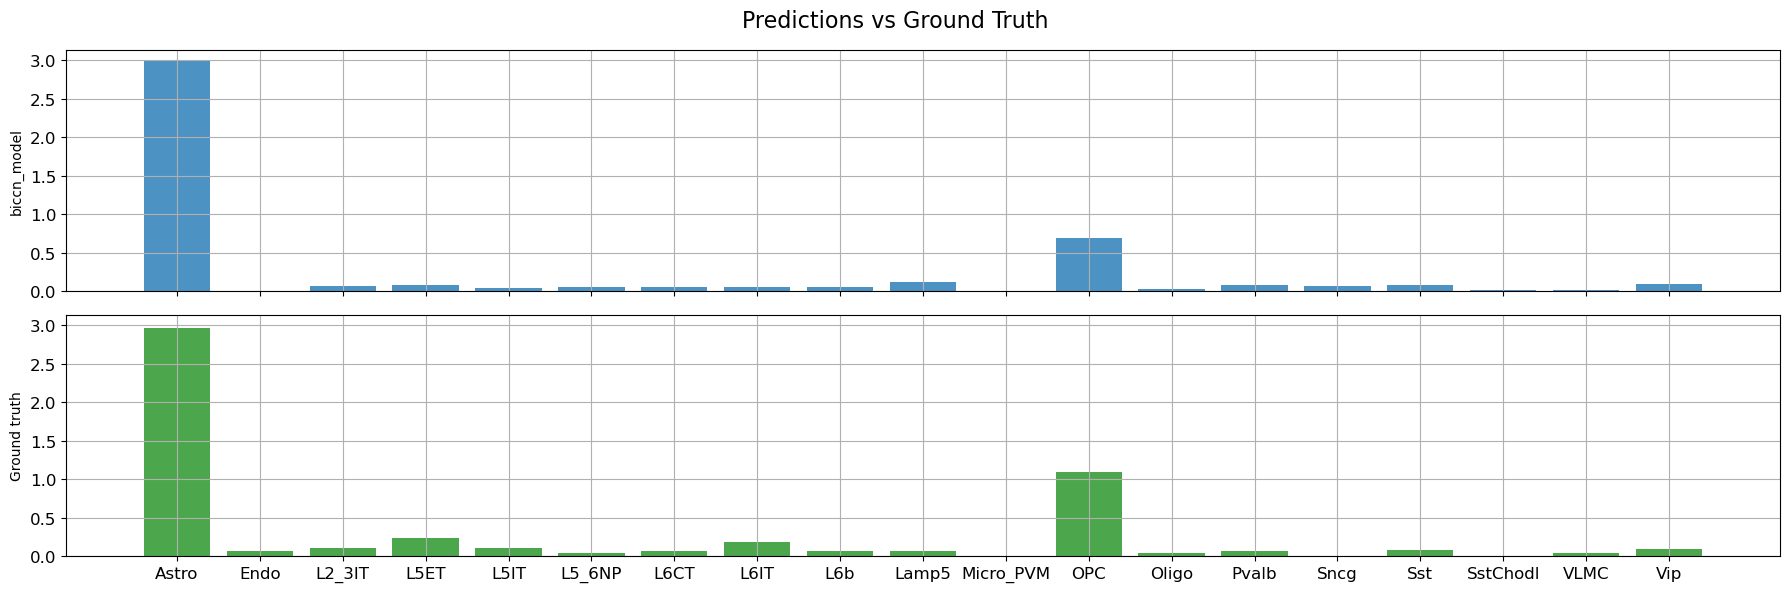

In [104]:
# plot predictions vs ground truth for a random region in the test set defined by index
idx = 56
region = adata.var.index[idx]
crested.pl.bar.region_predictions(
    adata, region, title="Predictions vs Ground Truth"
)

##### Example predictions on manually defined regions

In [141]:
from pysam import FastaFile
genome = FastaFile(genome_file)

chrom = 'chr18'
start = 61107770
end = 61109884

sequence = genome.fetch(chrom,start, end).upper()

prediction = evaluator.predict_sequence(sequence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


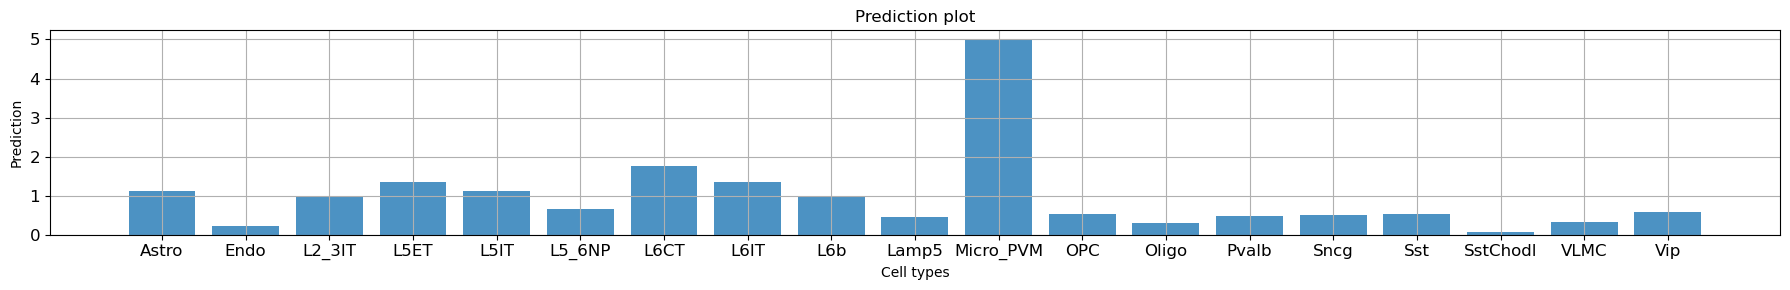

In [145]:
from crested.pl.bar import prediction_bar
prediction_bar(prediction, classes=list(adata.obs_names))

#### Model performance on the entire test set

After looking at specific instances, now we can look at the model performance on a larger scale.

First, we can check per cell type/class the correlation of predictions and peak heights over the peaks in the test set.

In [150]:
adata.layers

Layers with keys: 

2024-09-25T14:52:50.152439+0200 INFO Plotting density scatter for class: L2_3IT, models: ['biccn_model'], split: test


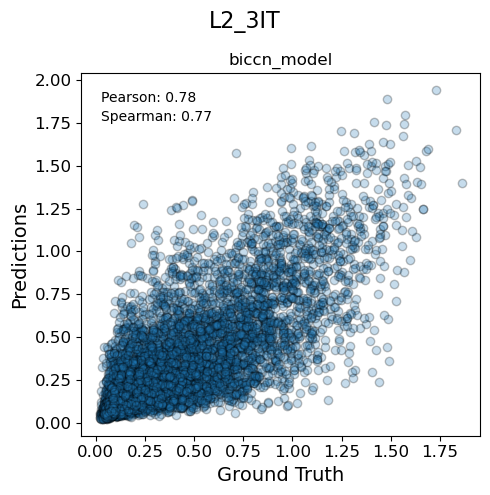

In [154]:
classn = 'L2_3IT'
crested.pl.scatter.class_density(
    adata,
    class_name=classn,
    model_names=["biccn_model"],
    split="test",
    log_transform=True,
    width=5,
    height=5,
)

To now check the correlations between all classes, we can plot a heatmap to assess the model performance.

2024-09-25T14:59:15.860827+0200 INFO Plotting heatmap correlations for split: test, models: ['biccn_model']


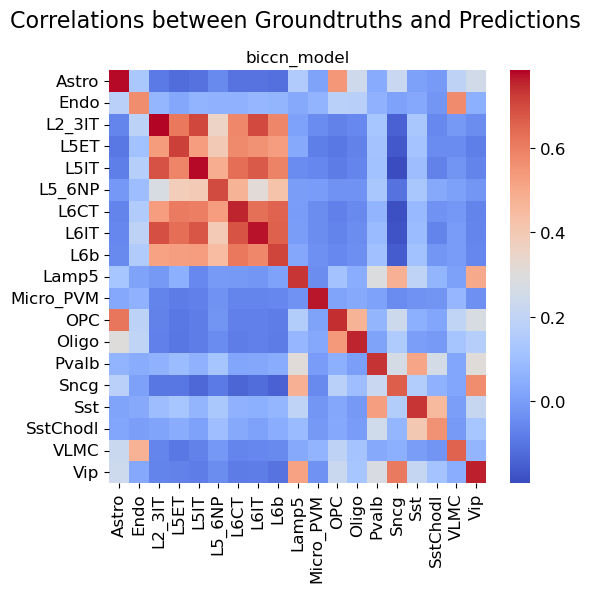

In [161]:
crested.pl.heatmap.correlations_predictions(
    adata,
    split="test",
    title="Correlations between Groundtruths and Predictions",
    x_label_rotation=90,
    width=6,
    height=6,
    log_transform=True
)

It is also recommended to compare this heatmap to the self correlation plot of the peaks themselves. If peaks between cell types are correlated, then it is expected that predictions from non-matching classes for correlationg cell types will also be high.

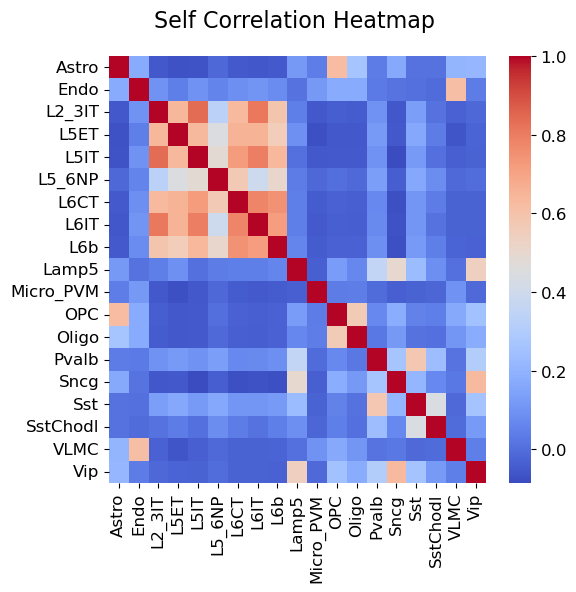

In [162]:
crested.pl.heatmap.correlations_self(
    adata, title="Self Correlation Heatmap", x_label_rotation=90, width=6, height=6
)

### Sequence contribution scores

We can calculate the contribution scores for a **sequence** of interest using the {meth}`~crested.tl.Crested.calculate_contribution_scores_sequence` method.  
You always need to ensure that the sequence or region you provide is the same length as the model input (2114bp in our case).  

#### Contribution scores on manually defined sequences

In [166]:
# random sequence of length 2114bp as an example
sequence = 'A'*2114

scores, one_hot_encoded_sequences = evaluator.calculate_contribution_scores_sequence(
    sequence, class_names=["Astro", "Endo"]
)  # focus on two cell types of interest

2024-09-25T15:06:43.411421+0200 INFO Calculating contribution scores for 2 class(es) and 1 region(s).


Region: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


#### Contribution scores on manually defined genomic regions

Alternatively, you can calculate contribution scores for **regions** of interest using the {meth}`~crested.tl.Crested.calculate_contribution_scores_regions` method.  
These regions don't have to be in your original dataset, as long as they exist in the genome file that you provided to the `AnnDataModule` and they are the same length as the model input.  

In [163]:
# focus on two cell types of interest
regions_of_interest = [
    "chr18:61107770-61109884"
]  # FIRE enhancer region, should only have motifs in Micro_PVM
classes_of_interest = ["Astro", "Micro_PVM", "L5ET"]
scores, one_hot_encoded_sequences = evaluator.calculate_contribution_scores_regions(
    region_idx=regions_of_interest, class_names=classes_of_interest
)

2024-09-25T15:04:20.978249+0200 INFO Calculating contribution scores for 3 class(es) and 1 region(s).


Region: 100%|██████████| 1/1 [00:05<00:00,  5.51s/it]


Contribution scores for regions can be plotted using the {func}`crested.pl.patterns.contribution_scores` function.  
This will generate a plot per class per region.

/data/projects/c04/cbd-saerts/nkemp/software/CREsted/src/crested/pl/_utils.py:80: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


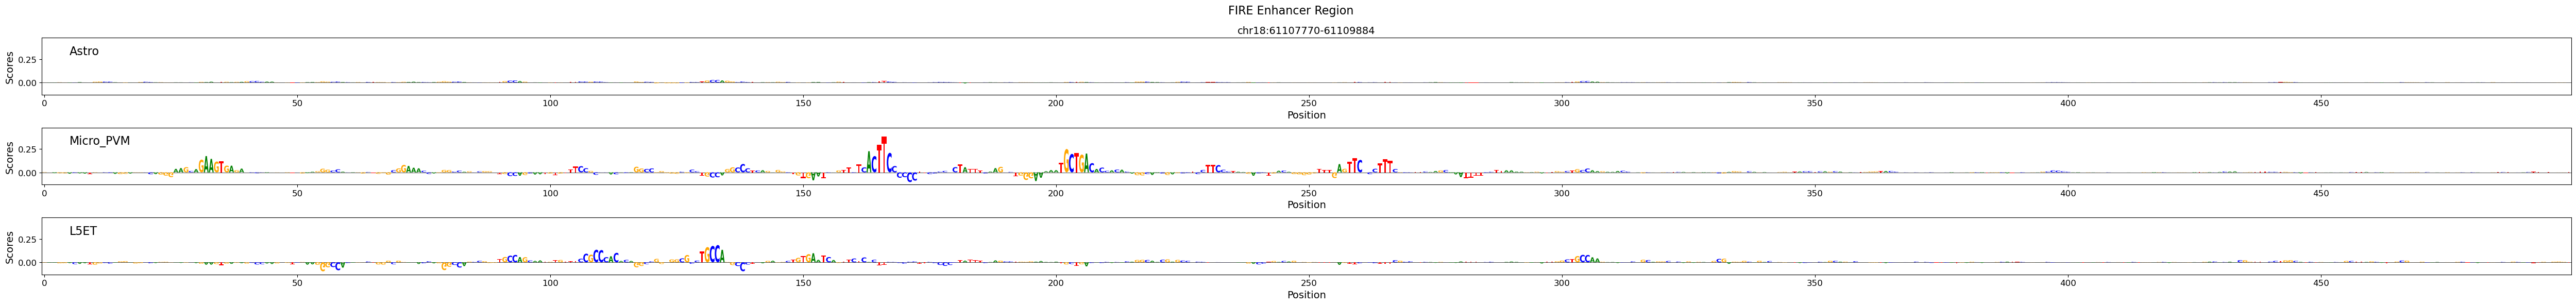

In [164]:
%matplotlib inline
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=regions_of_interest,
    class_labels=classes_of_interest,
    zoom_n_bases=500,
    title="FIRE Enhancer Region",
)  # zoom in on the center 500bp


#### Contribution scores on random test set regions

In [167]:
# plot predictions vs ground truth for a random region in the test set defined by index
idx = 56
region = adata.var.index[idx]
classes_of_interest = ["Astro", "OPC"]
scores, one_hot_encoded_sequences = evaluator.calculate_contribution_scores_regions(
    region_idx=region, class_names=classes_of_interest
)

2024-09-25T15:12:58.893808+0200 INFO Calculating contribution scores for 2 class(es) and 1 region(s).


Region: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


/data/projects/c04/cbd-saerts/nkemp/software/CREsted/src/crested/pl/_utils.py:80: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


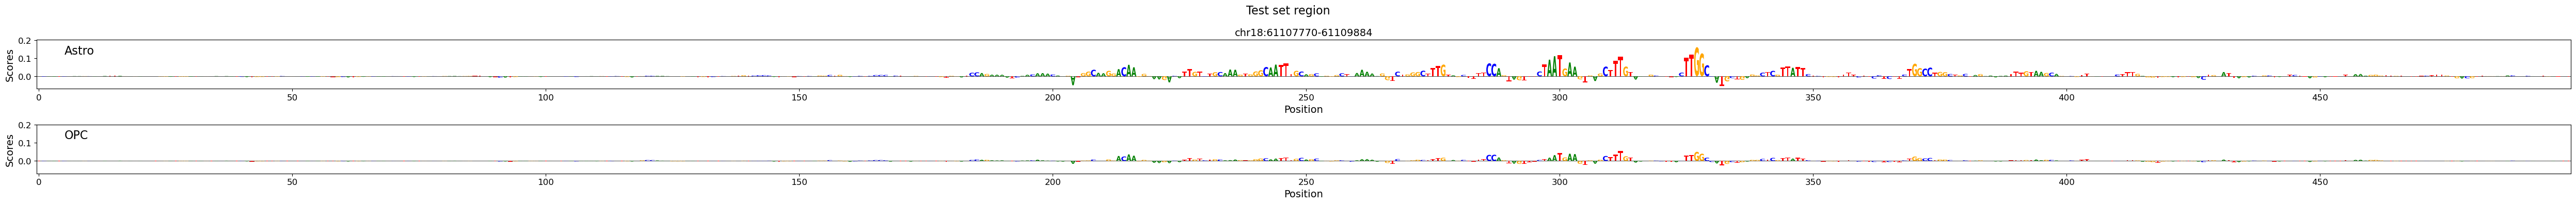

In [168]:
%matplotlib inline
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=regions_of_interest,
    class_labels=classes_of_interest,
    zoom_n_bases=500,
    title="Test set region",
)  # zoom in on the center 500bp

## Sequence evolution [more updates soon]

We can create synthetic enhancers for a specified class using in silico evolution with the {meth}`~crested.tl.Crested.enhancer_design_in_silico_evolution` method.

In [169]:
designed_sequences = evaluator.enhancer_design_in_silico_evolution(
    target_class="L5ET", n_sequences=1, n_mutations=15, target_len=500
)

2024-09-25T15:15:29.981295+0200 INFO Loading sequences into memory...


100%|██████████| 88835/88835 [00:01<00:00, 86678.67it/s]


47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [170]:
scores, one_hot_encoded_sequences = evaluator.calculate_contribution_scores_sequence(
    designed_sequences[0], class_names=["L5ET"]
)  # focus on two cell types of interest

2024-09-25T15:15:45.808261+0200 INFO Calculating contribution scores for 1 class(es) and 1 region(s).


Region: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


/data/projects/c04/cbd-saerts/nkemp/software/CREsted/src/crested/pl/_utils.py:80: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


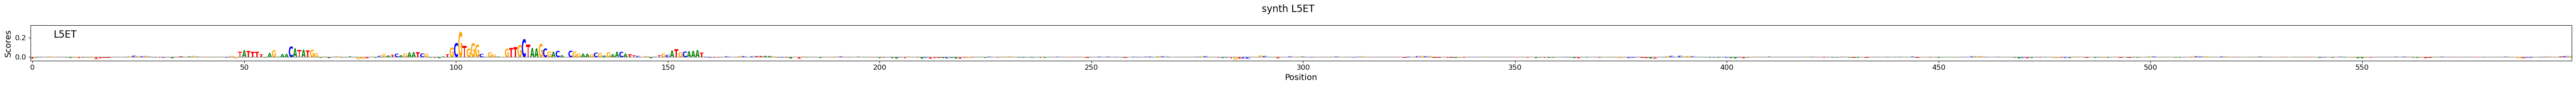

In [172]:
%matplotlib inline
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels="",
    class_labels=["L5ET"],
    zoom_n_bases=600,
    title="synth L5ET",
)  # zoom in on the center 600bp